In [1]:
%matplotlib inline
import itertools
import os
import numpy as np
import pandas as pd
from csv import reader
from scipy import signal
from scipy.signal import spectrogram

In [2]:
def has_metadata(csv_path):
    f = open(csv_path, newline='')
    csv_reader = reader(f)
    return True if next(csv_reader)[0] == '%OpenBCI Raw EEG Data' else False

def raw_read_bci_csv(csv_path):
    with open(csv_path, 'r') as f:
        csv_reader = reader(open(csv_path, newline=''))
        n_lines = 10 if next(csv_reader)[0] == '%OpenBCI Raw EEG Data' else 0
    column_names = [
        'sample_index', 'ch0', 'ch1', 'ch2', 'ch3', 'acc0',
        'acc1', 'acc2', 'label', 'provided_time', 'timestamp'
    ]
    dataset = pd.read_csv(csv_path, skiprows=n_lines, index_col=False, names=column_names)
    sample_rate = 200.
    dataset['time'] = dataset.index.values/sample_rate
    return dataset

def clean_read_bci_csv(csv_path):
    dataset = raw_read_bci_csv(csv_path)
    dataset.drop(
        columns=['sample_index', 'acc0', 'acc1', 'acc2', 'provided_time', 'timestamp'],
        inplace=True
    )
    return dataset

def add_sub_label(dataset):
    labels = dataset.label.unique().tolist()
    for label in labels:
        sample_idx = dataset.loc[dataset.label==label].index.values
        gap_btn_idx = sample_idx[1:] - sample_idx[:-1]
        selected_idx = np.insert((gap_btn_idx != 1), 0, True)
        desired_idx_bottom = sample_idx[selected_idx]
        selected_idx = np.append(selected_idx[1:],True)
        desired_idx_top = sample_idx[selected_idx]
        for k, (start, stop) in enumerate(zip(desired_idx_bottom, desired_idx_top)):
            selection = (dataset.index.values >= start) & (dataset.index.values <= stop)
            dataset.loc[selection, 'sub_label'] = f'{label}-{k}'
    return dataset

In [3]:
complete_dataset = pd.DataFrame()
datafiles_path = '/home/joaquin/Desktop/MentoriaDiploDatos/MetoriaBCI/Database'
csvs_list = os.listdir(datafiles_path)
for file in csvs_list:
    csv_path = os.path.join(datafiles_path, file)
    dataset = clean_read_bci_csv(csv_path)
    dataset = add_sub_label(dataset)
    dataset['subject'] = file[:2]
    dataset['session'] = file[3]
    dataset['sub_sess'] = dataset.subject + '-' + dataset.session
    complete_dataset = pd.concat([complete_dataset, dataset])
subset = complete_dataset.loc[complete_dataset.sub_sess=='AA-0']

Fs = 200
interval = int(Fs)
overlap = int(Fs * 0.95)
f, t, Sxx = spectrogram(
    subset.ch2.values,
    fs=Fs,
    nperseg=interval,
    noverlap=overlap)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

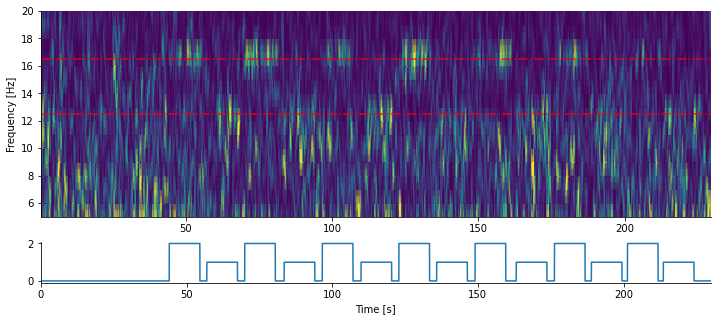

In [4]:
fig, (ax0, ax1) = plt.subplots(2,1, gridspec_kw={'height_ratios': [5, 1]}, figsize=(12,5))
ax0.pcolormesh(t, f,Sxx, cmap='viridis', vmax=10, shading='gouraud')
ax0.set_ylim([5, 20])
ax0.set_ylabel('Frequency [Hz]')
ax0.axhline(12.5, c='r', ls='-.', alpha=0.8)
ax0.axhline(16.5, c='r', ls='-.', alpha=0.8)

cmap = plt.get_cmap('tab10')
ax1.plot(subset.time.values, subset.label.replace(99,0).values)
ax1.set_xlim([0,subset.time.max()])
ax1.set_xlabel('Time [s]')
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

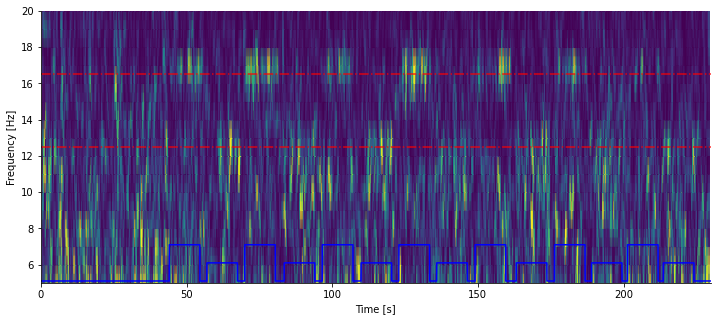

In [5]:
fig, ax0 = plt.subplots(1,1,figsize=(12,5))
ax0.pcolormesh(t, f,Sxx, cmap='viridis', vmax=10, shading='gouraud')
ax0.set_ylim([5, 20])
ax0.set_ylabel('Frequency [Hz]')
ax0.axhline(12.5, c='r', ls='-.', alpha=0.8)
ax0.axhline(16.5, c='r', ls='-.', alpha=0.8)
ax0.plot(subset.time.values, subset.label.replace(99,0).values+5.1, c='b')
ax0.set_xlim([0,subset.time.max()])
ax0.set_xlabel('Time [s]')
sns.despine()
plt.show()

In [6]:
intervalos = {'99': {'min':[], 'max':[]},'1':{'min':[], 'max':[]}, '2':{'min':[], 'max':[]}}

for ss in subset.sub_label.unique():
    for label in ['99-', '1-', '2-']:
        if label in ss:
            intervalos[label[:-1]]['min'].append(subset.loc[subset.sub_label==ss].time.min())
            intervalos[label[:-1]]['max'].append(subset.loc[subset.sub_label==ss].time.max())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

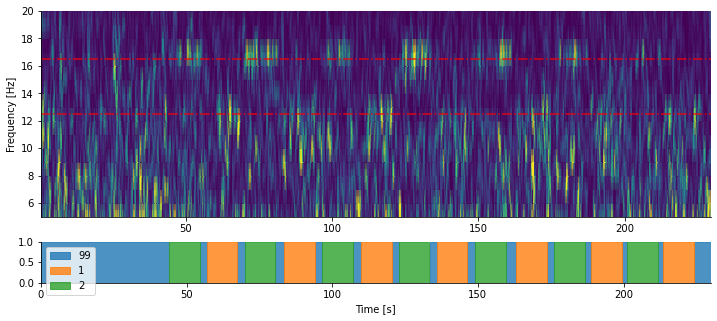

In [7]:
fig, (ax0, ax1) = plt.subplots(2,1, gridspec_kw={'height_ratios': [5, 1]}, figsize=(12,5))
ax0.pcolormesh(t, f,Sxx, cmap='viridis', vmax=10, shading='gouraud')
ax0.set_ylim([5, 20])
ax0.set_ylabel('Frequency [Hz]')
ax0.axhline(12.5, c='r', ls='-.', alpha=0.8)
ax0.axhline(16.5, c='r', ls='-.', alpha=0.8)

cmap = plt.get_cmap('tab10')
for k, intervalo in enumerate(intervalos.keys(),0):
    for i in range(len(intervalos[intervalo]['min'])):
        ax1.axvspan(xmin=intervalos[intervalo]['min'][i],
                    xmax=intervalos[intervalo]['max'][i],
                    color=cmap(k), alpha=0.8, label=intervalo if i == 0 else "")
ax1.set_xlim([0,subset.time.max()])
ax1.set_xlabel('Time [s]')
plt.legend()
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

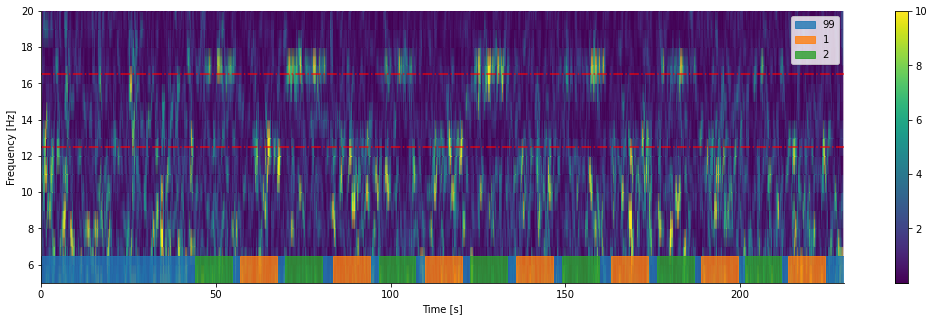

In [8]:
fig, ax0 = plt.subplots(1,1,figsize=(18,5))
im = ax0.pcolormesh(t, f,Sxx, cmap='viridis', vmax=10, shading='gouraud')# Plot the result
ax0.set_ylim([5, 20])             # ... set the frequency range,
ax0.set_ylabel('Frequency [Hz]')
fig.colorbar(im)
cmap = plt.get_cmap('tab10')
for k, intervalo in enumerate(intervalos.keys(),0):
    for i in range(len(intervalos[intervalo]['min'])):
        ax0.axvspan(xmin=intervalos[intervalo]['min'][i],
                    xmax=intervalos[intervalo]['max'][i], ymax=0.1,
                    color=cmap(k), alpha=0.8, label=intervalo if i == 0 else "")
ax0.axhline(12.5, c='r', ls='-.', alpha=0.8)
ax0.axhline(16.5, c='r', ls='-.', alpha=0.8)

ax0.set_xlim([0,subset.time.max()])
ax0.set_xlabel('Time [s]')
sns.despine()
plt.legend()
plt.show()